# Net generation and investigation of 2d net-generated cluster 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import random

## Grid generation with and without shell

In [34]:
def generate_filled_grid(n, fill_prob):
    return np.random.choice([0, 1], size=(n, n, n), p=[1 - fill_prob, fill_prob])

def generate_filled_grid_with_shell(n, node_prob, shell_prob):
    size_with_shells = n * 3
    nodes_index_range = range(1, size_with_shells, 3)

    res = np.zeros(shape=(size_with_shells, size_with_shells, size_with_shells), dtype=int)
    
    for i in nodes_index_range:
        for j in nodes_index_range:
            for k in nodes_index_range:     
                if random() <= node_prob:
                    res[i, j, k] = 1
                    if random() <= shell_prob:
                        res[i + 1, j, k] = 1
                    if random() <= shell_prob:
                        res[i - 1, j, k] = 1
                    if random() <= shell_prob:
                        res[i, j + 1, k] = 1
                    if random() <= shell_prob:
                        res[i, j - 1, k] = 1
                    if random() <= shell_prob:
                        res[i, j, k + 1] = 1
                    if random() <= shell_prob:
                        res[i, j, k - 1] = 1
    return res
    

In [38]:
def node_is_filled(z, y, x, arr):
    return arr[z, y, x] == 1

def connected(z, y, x, arr, direction):

    conn_dict= {
        "top": arr[z - 1, y, x] == arr[z - 2, y, x] == 1,
        "left": arr[z, y, x - 1] == arr[z, y, x - 2] == 1,
        "front": arr[z, y - 1, x] == arr[z, y - 2, x] == 1,
    }

    return conn_dict[direction]

def replace_marker(z, y, x, arr, old, new):
    old = (z, y, x)
    new = (z, y, x)

    if old == "top":
        old = (z - 1, y, x)
    if old == "front":
        old = (z, y - 1, x)
    if old == "left":
        old = (z, y, x - 1)

    if new == "top":
        new = (z - 1, y, x)
    if new == "front":
        new = (z, y - 1, x)
    if new == "left":
        new = (z, y, x - 1)

    return np.where(arr == arr[old], arr[new], arr)


In [60]:
def get_indices_for_marker_faces(res_voxel):
    x, y, z = np.indices(np.array(res_voxel.shape) + 1).astype(float) 
    
    x[1::2, :, :] += 1.0
    y[:, 1::2, :] += 1.0
    z[:, :, 1::2] += 1.0
    
    return x, y, z

In [239]:
def fill_marker_grid(arr):
    shape = arr.shape
    n = int(shape[0] // 3)
    shape = (int(shape[0] // 3), int(shape[1] // 3), int(shape[2] // 3))
    markers = np.zeros(shape)

    k = 0


    # check top left angle
    if node_is_filled(1, 1, 1, arr):
        k += 1
        markers[0, 0, 0] = k
    
    # check line on angle except top left angle
    for x in range(4, n * 3, 3):
        if node_is_filled(1, 1, x, arr):
            if connected(1, 1, x, arr, "left"):
                markers[0, 0, x // 3] = markers[0, 0, x // 3 - 1]
            else:
                k += 1
                markers[0, 0, x // 3] = k

    # check top face except top left angle and line on angle
    for y in range(4, n * 3, 3):
        # check left border of y-line
        if node_is_filled(1, y, 1, arr):
            if connected(1, y, 1, arr, "front"):
                markers[0, y // 3,  0] = markers[0, y // 3 - 1, 0]
            else:
                k += 1
                markers[0, y // 3, 0] = k

        # check y-line except left border
        for x in range(4, n * 3, 3):
            if node_is_filled(1, y, x, arr):
                if all([connected(1, y, x, arr, "front"),
                        connected(1, y, x, arr, "left")]):
                    markers[0, y // 3, x // 3] = markers[0, y // 3 - 1, x // 3]
                    replace_marker(0, y // 3, x // 3, arr, old="left", new="front")
                elif connected(1, y, x, arr, "front"):
                    markers[0, y // 3, x // 3] = markers[0, y // 3 - 1, x // 3]
                elif connected(1, y, x, arr, "left"):
                    markers[0, y // 3, x // 3] = markers[0, y // 3, x // 3 - 1]
                else:
                    k += 1
                    markers[0, y // 3, x // 3] = k

    # check all slices except top face
    for z in range(4, n * 3, 3):

        # check top left angle of each slice except top face
        if node_is_filled(z, 1, 1, arr):
            if connected(z, 1, 1, arr, "top"):
                markers[z // 3, 0, 0] = markers[z // 3 - 1, 0, 0]
            else: 
                k += 1
                markers[z // 3, 0, 0] = k

        # check line on top front angle of each slice except top face and front left angle 
        for x in range(4, n * 3, 3):
            if node_is_filled(z, 1, x, arr):
                if all([connected(z, 1, x, arr, "top"),
                        connected(z, 1, x, arr, "left")]):
                    markers[z // 3,  0, x // 3] = markers[z // 3 - 1, 0, x // 3]
                    replace_marker(z // 3, 0, x // 3, arr, old="left", new="top")
                elif connected(z, 1, x, arr, "top"):
                    markers[z // 3, 0, x // 3] = markers[z // 3 - 1, 0, x // 3]
                elif connected(z, 1, x, arr, "left"): 
                    markers[z // 3, 0, x // 3] = markers[z // 3, 0, x // 3 - 1]
                else:
                    k += 1
                    markers[z // 3, 0, x // 3] = k

        # check all lines in slice except front line
        for y in range(4, n * 3, 3):
            if node_is_filled(z, y, 1, arr):
                if all([connected(z, y, 1, arr, "top"),
                        connected(z, y, 1, arr, "front")]):
                    markers[z // 3, y // 3, 0] = markers[z // 3 - 1, y // 3 - 1, 0]
                    replace_marker(z // 3, y // 3, 0, arr, old="front", new="top")
                elif connected(z, y, 1, arr, "top"):
                    markers[z // 3, y // 3, 0] = markers[z // 3 - 1, y // 3, 0]
                elif connected(z, y, 1, arr, "front"):
                    markers[z // 3, y // 3, 0] = markers[z // 3, y // 3 - 1, 0]
                else:
                    k += 1
                    markers[z // 3, y // 3, 0] = k
            

            for x in range(4, n * 3, 3):
                if node_is_filled(z, y, x, arr):
                    if all([connected(z, y, x, arr, "top"),
                            connected(z, y, x, arr, "front"),
                            connected(z, y, x, arr, "left")]):
                        markers[z // 3, y // 3, x // 3] = markers[z // 3 - 1, y // 3, x // 3]
                        replace_marker(z // 3, y // 3, x // 3, arr, old="front", new="top")
                        replace_marker(z // 3, y // 3, x // 3, arr, old="left", new="top")
                    elif all([connected(z, y, x, arr, "top"),
                            connected(z, y, x, arr, "front")]):
                        markers[z // 3, y // 3, x // 3] = markers[z // 3 - 1, y // 3, x // 3]
                        replace_marker(z // 3, y // 3, x // 3, arr, old="front", new="top")
                    elif all([connected(z, y, x, arr, "top"),
                            connected(z, y, x, arr, "left")]):
                        markers[z // 3, y // 3, x // 3] = markers[z // 3 - 1, y // 3, x // 3]
                        replace_marker(z // 3, y // 3, x // 3, arr, old="left", new="top")
                    elif all([connected(z, y, x, arr, "front"),
                            connected(z, y, x, arr, "left")]):
                        markers[z // 3, y // 3, x // 3] = markers[z // 3, y // 3 - 1, x // 3]
                        replace_marker(z // 3, y // 3, x // 3, arr, old="left", new="front")
                    elif connected(z, y, x, arr, "top"):
                        markers[z // 3, y // 3, x // 3] = markers[z // 3 - 1, y // 3, x // 3]
                    elif connected(z, y, x, arr, "front"):
                        markers[z // 3, y // 3, x // 3] = markers[z // 3, y // 3 - 1, x // 3]
                    elif connected(z, y, x, arr, "left"):
                        markers[z // 3, y // 3, x // 3] = markers[z // 3, y // 3, x // 3 - 1]
                    else:
                        k += 1
                        markers[z // 3, y // 3, z // 3] = k


    return markers.astype(int)

In [36]:
def split_voxels(n, grid):
    res_nodes = np.full((n * 3, n * 3, n * 3), False)
    res_shells = np.full((n * 3, n * 3, n * 3), False)

    size_with_shells = n * 3
    nodes_index_range = range(1, size_with_shells, 3)
    

    for i in nodes_index_range:
        for j in nodes_index_range:
            for k in nodes_index_range:
                if grid[i, j, k] == 1:
                    res_nodes[i, j, k] = True
                    res_shells[i - 1, j, k] = grid[i - 1, j, k] == 1
                    res_shells[i + 1, j, k] = grid[i + 1, j, k] == 1
                    res_shells[i, j - 1, k] = grid[i, j - 1, k] == 1
                    res_shells[i, j + 1, k] = grid[i, j + 1, k] == 1
                    res_shells[i, j, k - 1] = grid[i, j, k - 1] == 1
                    res_shells[i, j, k + 1] = grid[i, j, k + 1] == 1

    return res_nodes, res_shells
    
def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

def get_indices_for_faces(res_voxel):
    x, y, z = np.indices(np.array(res_voxel.shape) + 1).astype(float) 
    x[2::6, :, :] -= 1.0
    x[3::6, :, :] += 1.5
    x[4::6, :, :] += 0.5
    x[5::6, :, :] += 0.5
    x[6::6, :, :] -= 0.5
    
    y[:, 2::6, :] -= 1.0
    y[:, 3::6, :] += 1.5
    y[:, 4::6, :] += 0.5
    y[:, 5::6, :] += 0.5
    y[:, 6::6, :] -= 0.5

    z[:, :, 2::6] -= 1.0
    z[:, :, 3::6] += 1.5
    z[:, :, 4::6] += 0.5
    z[:, :, 5::6] += 0.5
    z[:, :, 6::6] -= 0.5
    return x, y, z

In [163]:
def display_grid_with_shells(raw_arr, figure, vmin=None, vmax=None):
    arr = np.zeros(raw_arr.shape)

    for i in range(n * 3):
        for j in range(n * 3):
            for k in range(n * 3):
                arr[i, j, k] = raw_arr[k, n * 3 - j - 1, i]

    node_voxels, shell_voxels = split_voxels(n, arr)

    res_voxel = node_voxels | shell_voxels

    facecolors = np.empty(res_voxel.shape, dtype=object)
    edgecolors = np.empty(res_voxel.shape, dtype=object)

    facecolors[shell_voxels] = '#cccccc48'
    facecolors[node_voxels] = '#000000'

    res_voxel_e = explode(res_voxel)
    facecolors_e = explode(facecolors)
    x, y, z = get_indices_for_faces(res_voxel_e)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.invert_zaxis()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.voxels(x,y,z,res_voxel_e, facecolors=facecolors_e) 

    plt.show()

In [190]:
def hsv_to_rgb(h, s, v):
    if s == 0.0: v*=255; return (v, v, v)
    i = int(h*6.) # XXX assume int() truncates!
    f = (h*6.)-i; p,q,t = int(255*(v*(1.-s))), int(255*(v*(1.-s*f))), int(255*(v*(1.-s*(1.-f)))); v*=255; i%=6
    if i == 0: return (v, t, p)
    if i == 1: return (q, v, p)
    if i == 2: return (p, v, t)
    if i == 3: return (p, q, v)
    if i == 4: return (t, p, v)
    if i == 5: return (v, p, q)

In [235]:
def display_markers_grid(markers, figure, vmin=None, vmax=None):
    arr = np.zeros(markers.shape)
    res_voxel = np.full(markers.shape, False)

    for i in range(n):
        for j in range(n):
            for k in range(n):
                arr[i, j, k] = markers[k, n - j - 1, i]
                res_voxel[i, j, k] = arr[i, j, k] != 0

    clusters = []

    clusters_numbers = np.unique(arr)
    clusters_numbers = np.delete(clusters_numbers, 0)

    if len(clusters) == 0:
        min_cluster = clusters_numbers[0]
        max_cluster = clusters_numbers[-1]

        step = 1 / (max_cluster - min_cluster + 1)

        for each in clusters_numbers:
            clusters.append(np.where(arr == each, True, False))

        facecolors = np.empty(res_voxel.shape, dtype=object)

        for cluster, number in zip(clusters, clusters_numbers):
            r, g, b = hsv_to_rgb(number * step, 1, 1)
            r = '00' if hex(r)[2:] == '0' else hex(r)[2:]
            g = '00' if hex(g)[2:] == '0' else hex(g)[2:]
            b = '00' if hex(b)[2:] == '0' else hex(b)[2:]

            facecolors[cluster] = f'#{r}{g}{b}99'

        res_voxel_e = explode(res_voxel)
        facecolors_e = explode(facecolors)
        x, y, z = get_indices_for_marker_faces(res_voxel_e)

        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.invert_zaxis()
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.voxels(x, y, z, res_voxel_e, facecolors=facecolors_e) 

        plt.show()
    else:
        print("No clusters found")

In [264]:
def get_counts_per_cluster(data):
    index, count = np.unique(data, return_counts=True)
    return list(zip(index, count))[1:]

def is_conductive_cluster_present(data):
    have_conductive = False

    for i in get_counts_per_cluster(markers):
        if i[1] > n:
            have_conductive = True
            break
    
    return have_conductive

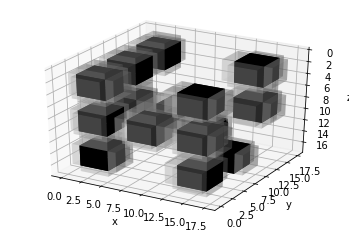

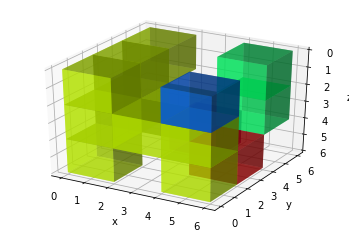

System have conductive cluster: True


In [269]:
n = 3
node_probability = 0.5
shell_probability = 0.8

grid = generate_filled_grid_with_shell(n, node_probability, shell_probability)
display_grid_with_shells(grid, "init_grid_with_shells")

markers = fill_marker_grid(grid)
display_markers_grid(markers, "colored_clusters")

print("System have conductive cluster: " + str(is_conductive_cluster_present(markers)))